## Pytorch Implementation of [Neural Combinatorial Optimization with Reinforcement Learning](https://arxiv.org/pdf/1611.09940.pdf)

Thanks for [neural-combinatorial-rl-pytorch](https://github.com/pemami4911/neural-combinatorial-rl-pytorch) and [combinatorial optimization with DL/RL](https://github.com/higgsfield/np-hard-deep-reinforcement-learning). Their work helps me understand the theory in paper and fix debugs in my codes. I also used some of their codes. 

In [63]:
import math
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim import lr_scheduler

%matplotlib inline

In [64]:
from IPython.display import clear_output
USE_CUDA = True

### Pointer Network

#### Encoder

* One layer of LSTM with (embedding_dim, hidden_dim)
* Initialize h, c with zeros
* Output
    * a sequence of latent memory states $\{enc_i\}_{i=1}^n$, where $\{enc_i\} \in \mathbb{R}^d$, d is embedding dimension
    * h: last layer hidden states, h\[-1\] is the hidden state in the last cell
    * c: last layer cell states, c\[-1\] is the cell state in the last cell

In [65]:
class Encoder(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        # use default number of layers is 1
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden_dim = hidden_dim
    
    def forward(self, embedding_x):
        '''
        Args:
        embedding_x (tensor): shape (sequence length, batch, input_dim)
        hidden (tensor): shape (num_layer * num_direction, batch_size, hidden_dim)
        
        Return:
        output (tensor): (sequence length, batch_size, hidden_dim)
        next_hidden (tensor): (num_layer * num_direction, batch_size, hidden_dim)
        '''
        output, next_hidden = self.lstm(embedding_x)
        return output, next_hidden

#### Attention and Glimpse (Pointing and Attending Mechanism)

* Input:
    * a query vector from decoder, $q = dec_i \in \mathbb{R}^d$
    * a set of reference vector from encoder output, $ref = \{enc_i, \dots, enc_k\}$， k could be the sequence length
* Pointing mechanism:
    $$u_i = \begin{cases} v^T \cdot \tanh (W_{ref} \cdot r_t + W_q \cdot q) \hspace{0.2cm} \text{if} \hspace{0.2cm} i \neq \pi(j) \hspace{0.2cm} \text{for all} \hspace{0.2cm} j < i \\
    -\infty\end{cases}  \hspace{0.2cm} \text{for}  \hspace{0.2cm} i = 1, 2, \dots k$$
    where $W_{ref}, W_q \in \mathbb{R}^{d \times d}$ and an attention vector $v \in \mathbb{R}^d$. In practice, the $reference$ input is (batch size $\times$ embedding dimension $\times$ sequence length), we can use convolution weights with shape (embedding dimensions, embedding dimensions) to address 3D data. $v$ initializes with normal distribution between $\left[-\frac{1}{\sqrt{d}}, \frac{1}{\sqrt{d}}\right]$ In the paper, it is $\left[-0.08 (-\frac{1}{\sqrt{128}}), 0.08\right]$. 
    $$A(ref, q; W_{ref}, W_q, v) = softmax(u)$$
    * Improving exploration
        * Softmax temperature
          $$A(ref, q; W_{ref}, W_q, v) = softmax(u / T)$$
          where $T$ is the temperature hyperparameter set to T = 1 during training. $T>1$, $A$ is more smooth, so that is prevent the model from being overconfident
        * Logit clipping (used here)
          $$A(ref, q; W_{ref}, W_q, v) = softmax(C \tanh(u))$$
          where $C$ is the hyperparameter that controls the range of the logits. The paper uses $C = 10$
* Attending mechanism
    $$p = A(ref, q; W_{ref}, W_q, v)$$
    $$G(ref, q; W_{ref}^g, W_q^g, v^g) = \sum_{i = 1}^k r_i p_i$$
    where $G$ is the glimpse function. It can be applied multiple times on the same reference set $ref$:
    $$g_0 = q$$
    $$g_l = G(ref, g_{l-1}; W_{ref}^q, W_q^g, v^g)$$
    The paper says more than once glimpse lead to barely improve thre results. Thus, we choose $\textbf{num_glimpse} = 1$. Glimpse function is implemented in the decoder. 

In [66]:
class Attention(nn.Module):
    def __init__(self, dim, C = 10, use_logit_clip = True, use_cuda = USE_CUDA):
        super().__init__()
        self.w_q = nn.Linear(dim, dim) # for query (batch_size, d)
        self.w_ref = nn.Conv1d(dim, dim, 1, 1) # for reference (batch_size, d, k)
        V = torch.Tensor(dim).float() # to trainable parameters
        if use_cuda:
            V = V.cuda()
        # initialize v by uniform in almost (-0.08, 0.08) from the paper
        self.v = nn.Parameter(V)
        self.v.data.uniform_(- 1. / math.sqrt(dim), 1. / math.sqrt(dim))
        self.tanh = nn.Tanh()
        self.C = C
        self.dim = dim
        self.use_logit_clip = use_logit_clip
    
    def forward(self, encoder_output, query):
        '''
        Args:
        k is sequence length
        encoder_output (tensor): shape is (k, batch_size, dim) from encoder_output
        query (tensor): shape is (batch_size, dim)
        
        Return:
        ref (tensor): shape is (batch_size, dim, k)
        logit (tensor): probability with shape (batch_size, k)
        '''
        batch_size = query.size(0)
        encoder_output = encoder_output.permute(1, 2, 0)
        # make sure ref shape is (batch_size, dim, k)
        
        q = self.w_q(query).unsqueeze(2)
        ref = self.w_ref(encoder_output) # batch_size, hidden_dim, k
        k = ref.size(2)
        expanded_q = q.repeat(1, 1, k)
        expanded_v = self.v.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1)
        # batch matrix multiply (batch_size, sequence_length)
        u = torch.bmm(expanded_v, self.tanh(ref + expanded_q)).squeeze(1)
        
        if self.use_logit_clip:
            logit = self.C * self.tanh(u)
        else:
            logit = u
            
        # return ref for glimpse
        return logit

### Mask

In [137]:
# mask already search index 
def mask_logit(logit, mask, prev_idx):
    '''
    mask logit probability if they are in previous indice
    Args:
    logit (tensor): from attention output with shape (batch_size, sequence length)
    mask (tensor or None): selected mask
    prev_idx (tensor): None or previous retrieved indice (batch_size, )
    
    Return:
    logit (tensor): same shape with input, but mask elements
    
    '''
    req = 4
    batch_size = logit.size(0)
    zeros = torch.zeros(batch_size)
    mask_copy = mask.clone()
    mask_copy_0 = mask.clone()

    # first index should be depot
    logit = logit.clone()

    # if prev_idx is None:
    #     mask_copy[[b for b in range(batch_size)], 1:] = 1
    #     print(logit)
    #     mask_copy_0[[b for b in range(batch_size)], 1:] = 0
    #     logit[mask_copy_0] = 5
    #     print(mask_copy[34])
    #     return logit, mask_copy



    # batch_size = logit.size(0)
    if prev_idx is not None:
        # print(prev_idx)
        mask_copy[[b for b in range(batch_size)], prev_idx.data] = 1
        # print("mask:",mask_copy[34])
        logit[mask_copy] = -np.inf
        # print("logit:",logit[34])
    
    return logit, mask_copy

#### Decoder

It also maintains its latent memory states $\{dec_i\}_{i=1}^n$, where $dec_i \in \mathbb{R}^d$.
* Input:
    * encoder last cell output: hidden state and cell state
    * decoder input initializes with normal distribution between $\left[-\frac{1}{\sqrt{d}}, \frac{1}{\sqrt{d}}\right]$. It should be trainable parameters.

In [114]:
class Decoder(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, sequence_length, 
                 decoder_type = "sampling", num_glimpse = 1, use_cuda = USE_CUDA):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_glimpse = num_glimpse
        self.sequence_length = sequence_length
        
        # lstm cell weights
        self.lstm_cell = nn.LSTMCell(embedding_dim, hidden_dim)
        
        # pointer and glimpse
        self.pointer = Attention(hidden_dim, use_cuda = use_cuda)
        self.glimpse = Attention(hidden_dim, use_logit_clip=False, use_cuda = use_cuda)
        self.use_cuda = use_cuda
        
        self.softmax = nn.Softmax()
        
        self.decoder_type = decoder_type
    
    def forward(self, decoder_input, embedding_x, hidden, encoder_output):
        '''
        Args:
        decoder_input (tensor): (batch_size, embedding_dim)
        embedding_x (tensor): (k, batch_size, embedding_dim)
        hidden (tuple): (h, c), initially, 
                    (encoder_output[-1], encoder_output[-1]), (batch_size, hidden_dim)
        encoder_output (tensor): encoder output, shape is (k, batch_size, embedding_dim)
        
        Return:
        prob_list (list): list of probability through the sequence 
        index_list (list): list of indice
        hidden (tuple): last layer hidden state and cell state
        '''
        batch_size = decoder_input.size(0)
        seq_len = embedding_x.size(0)
        # save result
        prob_list = []
        index_list = []
        mask = None
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
        prev_idx = None
        
        embedding_x = embedding_x.permute(1, 0, 2) # to (batch_size, seq_len, embedding_dim)
        ref = encoder_output.permute(1, 2, 0) # to (batch_size, embedding_dim, seq_len)
        for i in range(self.sequence_length):
            h, c = self.lstm_cell(decoder_input, hidden)
            hidden = (h, c)
            g_l = h  # (batch_size, hidden_dim)
            for _ in range(self.num_glimpse):
                logit = self.glimpse(encoder_output, g_l)
                logit, mask = mask_logit(logit, mask, prev_idx)
                p = self.softmax(logit) # (batch_size, seq_len)
                # ref (batch_size, hidden_dim, seq_len)
                g_l = torch.bmm(ref, p.unsqueeze(2)).squeeze(2) # (batch_size, hidden_dim)
            logit = self.pointer(encoder_output, g_l)
            logit_mask, mask = mask_logit(logit, mask, prev_idx)

            if self.decoder_type == "greedy": # for validation
                probs = self.softmax(logit_mask) # batch_size, k
                prev_idx, decoder_input = greedy(probs, embedding_x)
            elif self.decoder_type == "sampling": # for training
                probs = self.softmax(softmax_temperature(logit_mask, T = 1.) )# batch_size, k
                # print(probs)
                prev_idx, decoder_input = sampling(probs, embedding_x, index_list)
            else:
                raise NotImplementedError
            # record previous index 
            index_list.append(prev_idx)
            # record probability (like lstm output)
            prob_list.append(probs)
        return prob_list, index_list

#### Search Strategies

In [69]:
def greedy(probs, embedding_x):
    '''
    greedy search and return the index with 
    the biggest probability used in validation set
    
    Args:  
    probs (tensor): (batch_size, k)
    embedding_x (tensor): (k, batch_size, embedding_dim)
    
    Return:
    -- new_decoder_input (tensor): selected embedding x with shape (batch_size, embedding_dim)
    as new decoder_input
    -- idx (tensor): selected idx tensor （k,)
    '''
    batch_size = probs.size(0)
    idx = torch.argmax(probs, dim = 1).long()
    new_decoder_input = embedding_x[[x for x in range(batch_size)], idx.data, :]
    return idx, new_decoder_input

def sampling(probs, embedding_x, prev_idx):
    '''
    sampling indice from probability used in train and validation is ok
    
    Args:
    probs (tensor): (batch_size, k)
    embedding_x (tensor): (k, batch_size, embedding_dim)
    prev_idx (list): list of previous index (batch_size, 1), should be LongTensor
    
    Return:
    -- new_decoder_input (tensor): selected embedding x with shape (batch_size, embedding_dim)
    as new decoder_input
    -- idx (tensor): selected idx tensor （k,)
    '''
    batch_size = probs.size(0)
    idx = probs.multinomial(1).squeeze(1).long()
    
    def is_exist(idx, prev_idx):
        for old_idx in prev_idx:
            if old_idx.eq(idx).data.any():
                return True
        return False
    
    while is_exist(idx, prev_idx):
        idx = probs.multinomial(1).squeeze(1).long()  
    
    return idx, embedding_x[[x for x in range(batch_size)], idx.data, :]

def softmax_temperature(logit_mask, T = 2.):
    '''
    Implement softmax temperature strategy
    
    Args:
    logit_mask (batch_size, seq_len)
    T (float): temperature
    '''
    return logit_mask / T

def active_search(self):
    "TO DO"    
    pass

#### Pointer Network Module

Note that we should embed the raw input for the input of the network. Here I spent much time fixing bugs. The embedding for encoders should be shared for a sequence length of LSTM cells inputs, otherwise it will take much time to learn. 

In [70]:
class Embedding(nn.Module):
    def __init__(self, input_size, embedding_size, use_cuda = USE_CUDA):
        super().__init__()
        self.embedding_size = embedding_size
        
        self.embedding = nn.Parameter(torch.FloatTensor(input_size, embedding_size)) 
        self.embedding.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
    def forward(self, inputs):
        '''
        Args:
        inputs (batch_size, seq_len, input_size)
        
        Return:
        embedded (batch_size, seq_len, hidden_size)
        '''
        if USE_CUDA:
          inputs = inputs.cuda()
        batch_size = inputs.size(0)
        seq_len    = inputs.size(1)
        embedding = self.embedding.repeat(batch_size, 1, 1) # batch_size, input_size, embedding_size
        embedded = []
        for i in range(seq_len):
            # batch multiplication should be same dimensions, so, unsqueeze 1
            embedded.append(torch.bmm(inputs[:, i, :].unsqueeze(1).float(), embedding))
        embedded = torch.cat(embedded, 1)
        return embedded

In [71]:
class PointerNet(nn.Module): 
    
    def __init__(self, embedding_dim, hidden_dim, \
                 seq_length, \
                 decoder_type = "sampling", num_glimpse = 1, use_cuda = USE_CUDA):
        super().__init__()
        
        # define encoder and decoder
        self.encoder = Encoder(embedding_dim, hidden_dim)
        self.decoder = Decoder(embedding_dim, hidden_dim, \
                               seq_length, \
                               decoder_type = decoder_type, \
                               num_glimpse = num_glimpse, use_cuda = use_cuda)

        decoder_input = torch.Tensor(embedding_dim).float()
        self.decoder_input = nn.Parameter(decoder_input) # trainable, default require grad is true
        self.decoder_input.data.uniform_(-1 / math.sqrt(embedding_dim), 1 / math.sqrt(embedding_dim))
        
        # embedding
        self.embedding = Embedding(input_dim, embedding_dim, use_cuda = use_cuda)
    
    def forward(self, x):
        '''
        propagate through the network
        Args:
        x (tensor): (batch_size, k, input_dim), like in paper, embedding dim = d
        
        Return:
        - prob_list (list): length is max length of decoder, 
                with the element shape (batch_size, sequence length), 
        - index_list (list): length is max length of decoder, 
                with the element shape (batch_size,)
        '''
        batch_size = x.size(0)
        embedding_x = self.embedding(x).permute(1, 0, 2)
        encoder_output, (encoder_ht, encoder_ct) = self.encoder(embedding_x)
        
        # last layer output h, c as decoder initial state
        hidden = (encoder_ht.squeeze(0), encoder_ct.squeeze(0)) # (batch_size, hidden_dim)

        decoder_input = self.decoder_input.unsqueeze(0).repeat(batch_size, 1)
        prob_list, index_list = self.decoder(decoder_input, embedding_x, hidden, encoder_output)
        
        return prob_list, index_list

### Critic Network for TSP

Map an input sequence $s$ into a baseline prediction $b_{\theta_v}(s)$, because the objective
$$\mathcal{L}(\theta_v) = \frac{1}{B} \sum_{i=1}^B \left\|b_{\theta_v}(s) - L(\pi_i | s_i) \right\|_2^2$$

* an LSTM encoder: same as the encode in pointer network
* an LSTM process block: performs P steps of computation over the hidden state $h$, update by glimpsing the memory state
* a 2-layer ReLU neural network decoder

In [72]:
class Critic(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, process_iters, use_logit_clip = False, use_cuda = USE_CUDA):
        super().__init__()
        self.encoder = Encoder(embedding_dim, hidden_dim)   
        self.process_block = Attention(hidden_dim, use_logit_clip=use_logit_clip, \
                                       use_cuda = use_cuda) # output is (batch_size, hidden_dim)
        self.decoder = nn.Sequential(
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, 1)
                        )
        self.process_iters = process_iters
        self.softmax = nn.Softmax()
        self.embedding = Embedding(input_dim, embedding_dim, use_cuda = use_cuda)
    
    def forward(self, x):
        '''
        Args:
        x (tensor): with shape (k, batch_size, embedding_dim)
        
        Return:
        output (tensor): (batch_size, 1)
        '''
        batch_size = x.size(0)
        embedding_x = self.embedding(x).permute(1, 0, 2)
        encoder_output, (encoder_ht, encoder_ct) = self.encoder(embedding_x)
        ref = encoder_output.permute(1, 2, 0) # to (batch_size, embedding_dim, seq_len)
        g_l = encoder_ht.squeeze(0)
        for p in range(self.process_iters):
            logit = self.process_block(encoder_output, g_l)
            p = self.softmax(logit) # (batch_size, k)
            g_l = torch.bmm(ref, p.unsqueeze(2)).squeeze(2)
        output = self.decoder(g_l)
        return output

#### Combinatorial Model

In [73]:
class Model(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, seq_len, batch_size = 128 ,process_iters = 3, use_cuda = USE_CUDA):
        super().__init__()
        self.pointer_net = PointerNet(embedding_dim, hidden_dim, seq_len, use_cuda = use_cuda)
        self.critic = Critic(embedding_dim, hidden_dim, process_iters, use_cuda = use_cuda)
        self.batch_size = batch_size
        self.seq_len = seq_len
            
    def forward(self, x):
        '''
        Args:
        x (batch_size, seq_len, input_dim)
        '''
        if USE_CUDA:
          x = x.cuda()
        prob_list, index_list = self.pointer_net(x)
        b = self.critic(x)
        
        pi = []
        probs = []
        for i, index in enumerate(index_list):

            pi_ = x[[j for j in range(self.batch_size)], index.data,:]
            pi.append(pi_)
            prob_ = prob_list[i]
            prob_ = prob_[[j for j in range(self.batch_size)], index.data]
            probs.append(prob_)
        
        L = tour_length(pi)
        log_probs = 0
        for prob in probs:
            log_prob = torch.log(prob)
            log_probs += log_prob
        
        return L, log_probs, pi, index_list, b

### Actor-Critic and Moving Average Training 

#### Calculate tour length

$$L(\pi | s) = \left\| x_{\pi(n)} - x_{\pi(1)} \right\|_2 + \sum_{i=1}^{n-1} \left\|x_{\pi(i)} - x_{\pi(i+1)} \right\|_2$$

In [74]:
# define tour length function as reward
def tour_length(pi, use_cuda = USE_CUDA):
    '''
    calculate the total length of the tour
    Args:
    pi (list): length is sequence length, 
                the element shape is (batch_size, point_size)
    Return:
    tour_len (tensor): (batch_size, 1)
    '''
    
    n = len(pi)
    batch_size = pi[0].size(0)
    tour_len = Variable(torch.zeros(batch_size))
    
    if use_cuda:
        tour_len = tour_len.cuda()
        
    for i in range(n-1):
        tour_len += torch.norm(pi[i+1] - pi[i], p = 2, dim = 1)
    tour_len += torch.norm(pi[n-1] - pi[0], p = 2, dim = 1)
    return tour_len

#### Hyperparameters

In [75]:
# hyperparameter
input_dim = 2
embedding_dim = 128
batch_size = 128
hidden_dim = 128
process_iters = 3
tsp_num = 9
train_size = 10000 #1000000
validation_size = 128
lr = 1e-4
beta = 0.9
num_glimpse = 1

#### Train and Validation Data

In [76]:
def generate_tsp_data():
    '''
    Generate tsp data
    
    Return:
    tsp_data (tensor): shape (1, tsp_num, input_dim)
    '''
    tsp_data = torch.FloatTensor(tsp_num, input_dim).uniform_(0, 1)
    return tsp_data.unsqueeze(0)

train_dataset = [generate_tsp_data() for _ in range(train_size)]
validation_dataset = [generate_tsp_data() for _ in range(validation_size)]
print("train dataset size: ", len(train_dataset))
print("validation dataset size: ", len(validation_dataset))

train dataset size:  10000
validation dataset size:  128


In [77]:
# training
class Train(object):
    
    def __init__(self, model, train_set, validation_set, batch_size = 128, max_grad_norm = 1., lr = 1e-4, update_steps = 5000):
        self.model = model
        self.train_set = train_set
        self.validation_set = validation_set
        self.batch_size = batch_size
        self.max_grad_norm = max_grad_norm
        self.optimizer_all = Adam(list(model.critic.parameters()) + list(model.pointer_net.parameters()), lr = lr)
        self.optimizer_pointer = Adam(model.pointer_net.parameters(), lr = lr)
        self.lr_scheduler_pointer = lr_scheduler.MultiStepLR(self.optimizer_pointer, \
                                                     list(range(update_steps, update_steps * 1000, update_steps)), gamma=0.96)
        self.lr_scheduler_all = lr_scheduler.MultiStepLR(self.optimizer_all, \
                                                     list(range(update_steps, update_steps * 1000, update_steps)), gamma=0.96)
        self.mse_loss = nn.MSELoss()
        self.input_dim = 2 # points dimension
        
        self.train_rewards = []
        self.val_rewards = []
    
    def train_and_validation(self, n_epoch, training_steps, use_critic = True):
        moving_average = 0
        for epoch in range(n_epoch):
            for step in range(training_steps):
                training_set = random.sample(self.train_set, batch_size)
                training_set = Variable(torch.cat(training_set).view(self.batch_size, -1, self.input_dim))
                L, log_probs, pi, index_list, b = self.model(training_set)

                log_probs = log_probs.view(-1)
                log_probs[(log_probs < -1000).detach()] = 0.
                
                if not use_critic:
                    if step == 0:
                        moving_average = L.mean()
                    else:
                        moving_average = (moving_average * beta) + ((1. - beta) * L.mean())

                    advantage = L - moving_average             
                    actor_loss = (advantage * log_probs).mean()
                    
                                    
                    self.optimizer_pointer.zero_grad()
                    actor_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.pointer_net.parameters(), self.max_grad_norm, norm_type=2)
                    self.optimizer_pointer.step()
                    self.lr_scheduler_pointer.step()
                    moving_average = moving_average.detach()
                         
                else:
                    critic_loss = self.mse_loss(b.view(-1), L)
                    advantage = L - b.view(-1)
                    actor_loss = (advantage * log_probs).mean()
                    loss = actor_loss + critic_loss
                    self.optimizer_all.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(list(self.model.critic.parameters()) + \
                                                   list(self.model.pointer_net.parameters()), self.max_grad_norm, norm_type=2)
#                     torch.nn.utils.clip_grad_norm_(, self.max_grad_norm, norm_type=2)
                    self.optimizer_all.step()
                    self.lr_scheduler_all.step()

                self.train_rewards.append(L.mean().data.cpu())
                
                if step % 10 == 0:
                    self.plot(epoch)
                if step % 100 == 0:
                    val_set = Variable(torch.cat(self.validation_set).view(len(self.validation_set), -1, self.input_dim))
                    L, log_probs, pi, index_list, b = self.model(val_set)
                    self.val_rewards.append(L.mean().data.cpu())  
                    
                # model save
                if step % 1000 == 0:
                    if use_critic:
                        torch.save(self.model, os.path.join(os.getcwd(), \
                                                            'model_tsp{}_critic.pt'.format(self.model.seq_len)))
                    else:
                        torch.save(self.model, os.path.join(os.getcwd(), \
                                                            'model_tsp{}_mvg_avg.pt'.format(self.model.seq_len)))
    
    def plot(self, epoch):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('train tour length: epoch %s reward %s' % (epoch, self.train_rewards[-1] if len(self.train_rewards) else 'collecting'))
        plt.plot(self.train_rewards)
        plt.grid()
        plt.subplot(132)
        plt.title('val tour length: epoch %s reward %s' % (epoch, self.val_rewards[-1] if len(self.val_rewards) else 'collecting'))
        plt.plot(self.val_rewards)
        plt.grid()
        plt.show() 

#### Moving average reward training, more stable

In [139]:
# moving average reward
moving_average_model = Model(embedding_dim, hidden_dim, seq_len = tsp_num)
if USE_CUDA:
    moving_average_model  = moving_average_model .cuda()
train = Train(moving_average_model , train_dataset, validation_dataset, lr = 1e-4)
train.train_and_validation(6, 1000, use_critic = False)

KeyboardInterrupt: ignored

In [84]:
val_set_t = Variable(torch.cat(validation_dataset).view(len(validation_dataset), -1, 2))

x = val_set_t

print(len(x))
L, log_probs, pi, index_list, b = train.model(x)

128
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', grad_fn=<CopySlices>)
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', grad_fn=<CopySlices>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1239.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [85]:

List_all = []
list1 =[]
pii,pii_x,pii_y = [],[],[]
Pi_all,Pi_all_x,Pi_all_y = [],[],[]
for j in range(len(x)):
  for i in range(9):
    list1.append(index_list[i][j].item())
    pii.append(pi[i][j].data)
    pii_x.append(pi[i][j].data[0].item())
    pii_y.append(pi[i][j].data[1].item())
  List_all.append(list1)
  Pi_all.append(pii)
  Pi_all_x.append(pii_x)
  Pi_all_y.append(pii_y)
  list1,pii,pii_x,pii_y =[],[],[],[]



print("index list: ", List_all[34])
print("Policy: ", Pi_all[34])
print("Policy_x: ", Pi_all_x[34])
print("Policy_y: ", Pi_all_y[34])
len(x)

index list:  [0, 7, 8, 5, 1, 2, 6, 4, 3]
Policy:  [tensor([0.3683, 0.9791], device='cuda:0'), tensor([0.2325, 0.8836], device='cuda:0'), tensor([0.9257, 0.9404], device='cuda:0'), tensor([0.8245, 0.6869], device='cuda:0'), tensor([0.4092, 0.5656], device='cuda:0'), tensor([0.8124, 0.5168], device='cuda:0'), tensor([0.2409, 0.3616], device='cuda:0'), tensor([0.0350, 0.1067], device='cuda:0'), tensor([0.7962, 0.2524], device='cuda:0')]
Policy_x:  [0.36829906702041626, 0.23254680633544922, 0.925687849521637, 0.8244538903236389, 0.4091513752937317, 0.8123952150344849, 0.24088406562805176, 0.034990906715393066, 0.7962075471878052]
Policy_y:  [0.979101836681366, 0.8835746645927429, 0.9403772950172424, 0.6868640184402466, 0.5656297206878662, 0.516813337802887, 0.361558735370636, 0.10671937465667725, 0.2524298429489136]


128

Plot

index list:  [7, 0, 8, 3, 6, 1, 2, 5, 4]
Policy:  [tensor([0.1998, 0.6514], device='cuda:0'), tensor([0.3465, 0.9441], device='cuda:0'), tensor([0.3189, 0.8775], device='cuda:0'), tensor([0.9594, 0.9574], device='cuda:0'), tensor([0.5401, 0.7951], device='cuda:0'), tensor([0.0610, 0.6100], device='cuda:0'), tensor([0.6402, 0.4644], device='cuda:0'), tensor([0.6549, 0.1989], device='cuda:0'), tensor([0.4512, 0.0444], device='cuda:0')]
Policy_x:  [0.199823260307312, 0.346465528011322, 0.31887030601501465, 0.9594174027442932, 0.5400610566139221, 0.06103640794754028, 0.6402432322502136, 0.6548980474472046, 0.4511580467224121]
Policy_y:  [0.6514014601707458, 0.944121241569519, 0.8774502873420715, 0.9573813676834106, 0.7951295971870422, 0.6100011467933655, 0.4643799662590027, 0.19891703128814697, 0.04441255331039429]


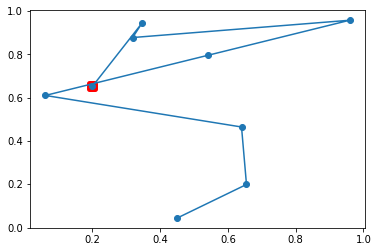

In [99]:
test_instance_no = 100#105
print("index list: ", List_all[test_instance_no])
print("Policy: ", Pi_all[test_instance_no])
print("Policy_x: ", Pi_all_x[test_instance_no])
print("Policy_y: ", Pi_all_y[test_instance_no])
x = Pi_all_x[test_instance_no]
y = Pi_all_y[test_instance_no]
plt.plot(x, y, "-o")
plt.scatter(x[0], y[0], c = "r", marker = "s", linewidths = 5)

In [ ]:
TIME_CO = 0.6
# define tour length function as reward
# 计算两点之间的距离
def distance_b(node1, node2):
    dis = torch.norm(node2 - node1, p = 2, dim = 1)
    return dis

# check who are on the car
def check(index_list, req_num):
    passengers_l = []
    for i in range(1, req_num+1):
      node_p = np.ones(1,int)*i
      node_d = np.ones(1,int)*(i+req_num)
      # if pick-up p but not drop
      if (node_p in index_list) and (node_d not in index_list):
        passengers_l.append(i)
      
    return passengers_l

# caculate single passenger travel time
def single_tr_time(p_id, pi, req_num, index_list,static_node_set):
    
    tour_len = Variable(torch.zeros(batch_size))

    node_p = np.ones(1,int)*p_id
    node_d = np.ones(1,int)*(p_id+req_num)


    # serve only the passenger p_id
    p = static_node_set[:, :2, :][:, :, p_id].squeeze(0)
    d = static_node_set[:, :2, :][:, :, p_id+req_num].squeeze(0)


    t_star = TIME_CO*distance_b(p, d)

    # pick-up and drop-off location in tour
    p_id_pick_up = index_list.index(node_p)
    # p_id_destination = index_list.index(node_d)

    des = static_node_set[:, :,  ]

    # current tour for passenger p_id
    tour_p_id = pi[p_id_pick_up:]

    n = len(tour_p_id)

    for i in range(n-1):
        tour_len += torch.norm(pi[i+1] - pi[i], p = 2, dim = 1)
    tour_len += torch.norm(pi[n-1] - d, p = 2, dim = 1)


    travel_time_p_id = TIME_CO * tour_len

    return travel_time_p_id

def travel_t(pi, index_list,req_num,static_node_set):
    # check who is on the car
    pass_on = check(index_list, req_num)
    travel_all = 0
    # caculate travel time for each passenger
    for p in pass_on:
      t_p = single_tr_time(p, pi, req_num, index_list, static_node_set)
      travel_all+=t_p

    return travel_all

def tour_length(pi, use_cuda = USE_CUDA):
    '''
    calculate the total length of the tour
    Args:
    pi (list): length is sequence length, 
                the element shape is (batch_size, point_size)
    Return:
    tour_len (tensor): (batch_size, 1)
    '''
    
    n = len(pi)
    batch_size = pi[0].size(0)
    tour_len = Variable(torch.zeros(batch_size))
    
    if use_cuda:
        tour_len = tour_len.cuda()
        
    for i in range(n-1):
        tour_len += torch.norm(pi[i+1] - pi[i], p = 2, dim = 1)
    tour_len += torch.norm(pi[n-1] - pi[0], p = 2, dim = 1)
    return tour_len

In [114]:
print(val_set_t[test_instance_no])

tensor([[0.1392, 0.1100],
        [0.5915, 0.7178],
        [0.0654, 0.9058],
        [0.5356, 0.1130],
        [0.3358, 0.4041],
        [0.5403, 0.6482],
        [0.8936, 0.5740],
        [0.6645, 0.3789],
        [0.1562, 0.7838]])


In [ ]:
modelss = torch.load('/content/model_tsp9_mvg_avg.pt')
L, log_probs, pi, index_list, b = modelss(val_set_t)
List_all = []
list1 =[]
pii,pii_x,pii_y = [],[],[]
Pi_all,Pi_all_x,Pi_all_y = [],[],[]
for j in range(len(x)):
  for i in range(9):
    list1.append(index_list[i][j].item())
    pii.append(pi[i][j].data)
    pii_x.append(pi[i][j].data[0].item())
    pii_y.append(pi[i][j].data[1].item())
  List_all.append(list1)
  Pi_all.append(pii)
  Pi_all_x.append(pii_x)
  Pi_all_y.append(pii_y)
  list1,pii,pii_x,pii_y =[],[],[],[]



print("index list: ", List_all[34])
print("Policy: ", Pi_all[34])
print("Policy_x: ", Pi_all_x[34])
print("Policy_y: ", Pi_all_y[34])



#### Actor-Critic training, converge more slowly, not stable, which might be worse sometimes.

I tried learning rate 1e-3 several times, and it might be explode sometimes. Thus, I used same learning rate 1e-4 as moving averages.

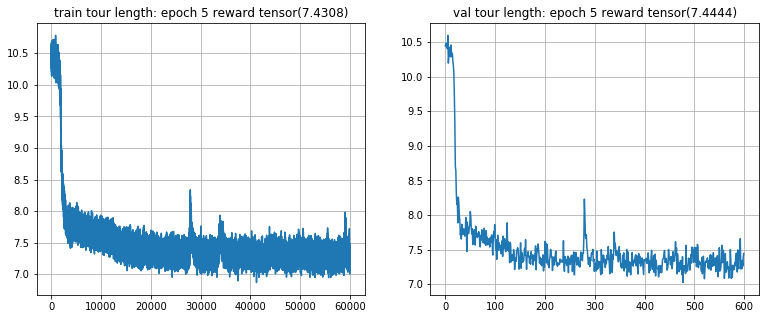

In [ ]:
# use critic
ac_model = Model(embedding_dim, hidden_dim, seq_len = tsp_num)
if USE_CUDA:
    ac_model  = ac_model.cuda()
train = Train(ac_model, train_dataset, validation_dataset, lr = 1e-4)
train.train_and_validation(6, 10000, use_critic = True)